# Case Study: Assessing Influences
*author: S.A. Klop*

This case study demonstrates how time series analysis can be used to identify different influences on groundwater head.

The focus is on determining whether an external factor—such as an abstraction—has a significant impact, and if so, how large that impact is. The case study is divided into two parts. The first part deals with an example involving an abstraction. In Part II, the influence of a watercourse on groundwater head is examined.

**Table of Contents**

- [Part I: Influence of Water Level Adjustment](#Part-I:-Influence-of-Water-Level-Adjustment)
    - [Available Data](#Available-Data-Example-1)
    - [Building the Time Series Model](#Building-the-Time-Series-Model-Example-1)
    - [Impact of the Intervention](#Impact-of-the-Intervention)
- [Part II: Influence of Watercourse](#Part-II:-Influence-of-Watercourse)
    - [Available Data](#Available-Data-Example-2)
    - [Preprocessing Time Series](#Preprocessing-Time-Series-Example-2)
    - [Setting Up the Model](#Setting-Up-the-Model-Example-2)
    - [Assessing the Influence of the Watercourse](#Assessing-the-Influence-of-the-Watercourse)


In [1]:
# inladen van de benodigde python packages
import pastas as ps
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML

%matplotlib inline
ps.set_log_level("ERROR")

%config InlineBackend.figure_format = 'retina'

/Applications/anaconda3/envs/mude/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (

## Part I: Influence of Water Level Adjustment

The water board has measured the groundwater head in Observation Well 1. This well is located in an area where, during the summer of 2005, the water board implemented measures to raise the groundwater level in order to improve the area's ecological value. These measures included raising several weirs and blocking some drainage ditches.

Ten years after these interventions, the water board wants to evaluate whether the measures had the intended effect on groundwater head. To do this, the groundwater head in Observation Well 1 is analyzed using time series analysis.

### Available Data Example 1

The figure below shows the measured groundwater head in Observation Well 1. The measurements cover the period from 1985 through 2015, both before and after the intervention. At first glance, it appears that the groundwater head has increased since the measures were implemented in the summer of 2005.

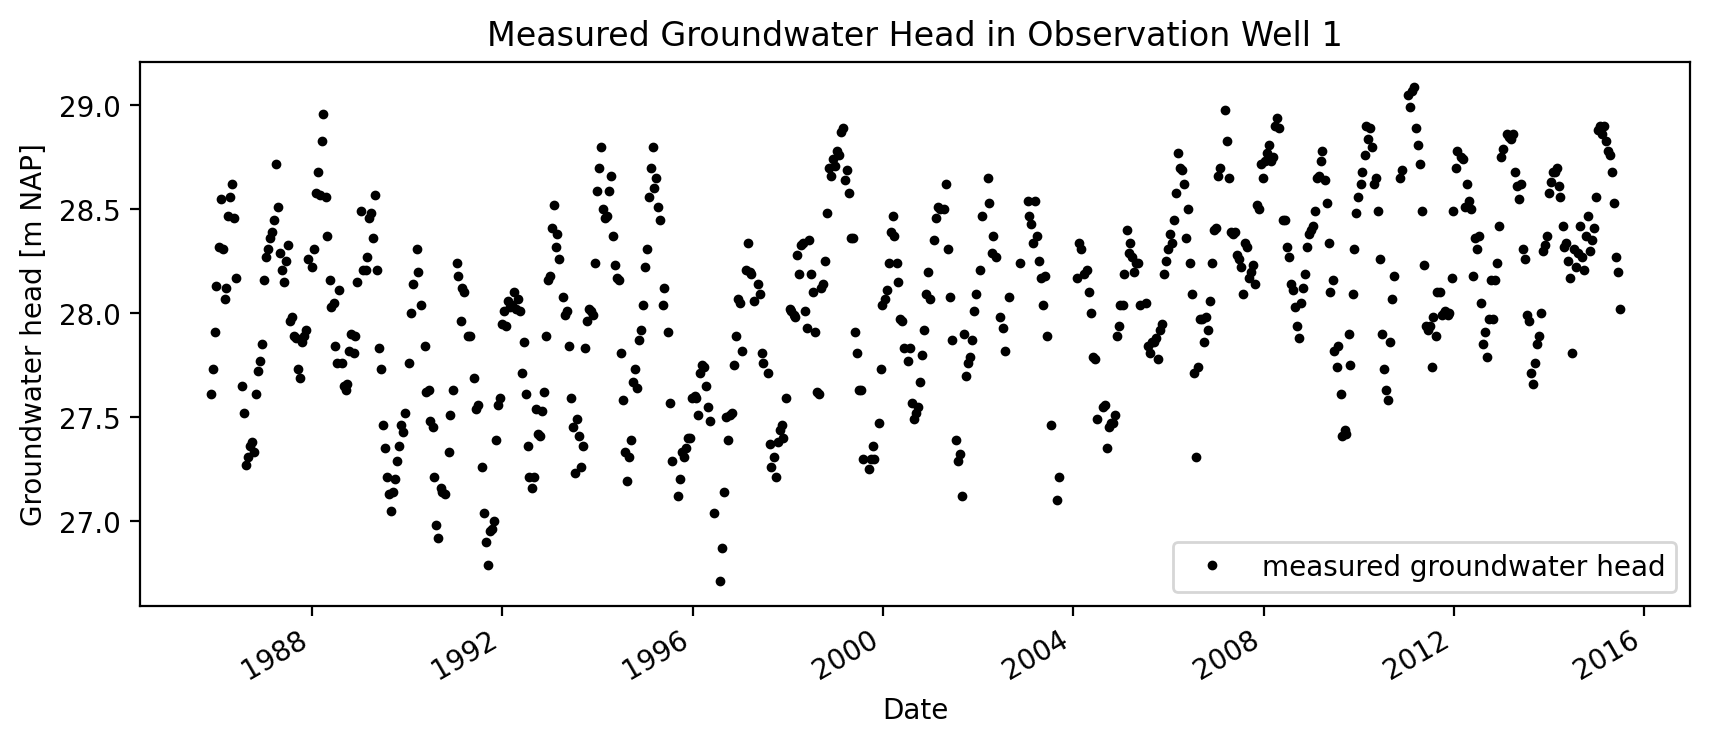

In [2]:
gws = pd.read_csv("data/head_stepex_edit.csv",
                  index_col=0, parse_dates=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws.plot(ax=ax, color='k', ls='', marker='.', markersize=5)

ax.set_ylabel('Groundwater head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured Groundwater Head in Observation Well 1')
ax.legend(['measured groundwater head'])

The precipitation and evaporation at the location of Observation Well 1 are used as explanatory series. For this, data from the nearest KNMI weather station were used. The precipitation and evaporation are shown in the figure below.

(6209.0, 17127.0)

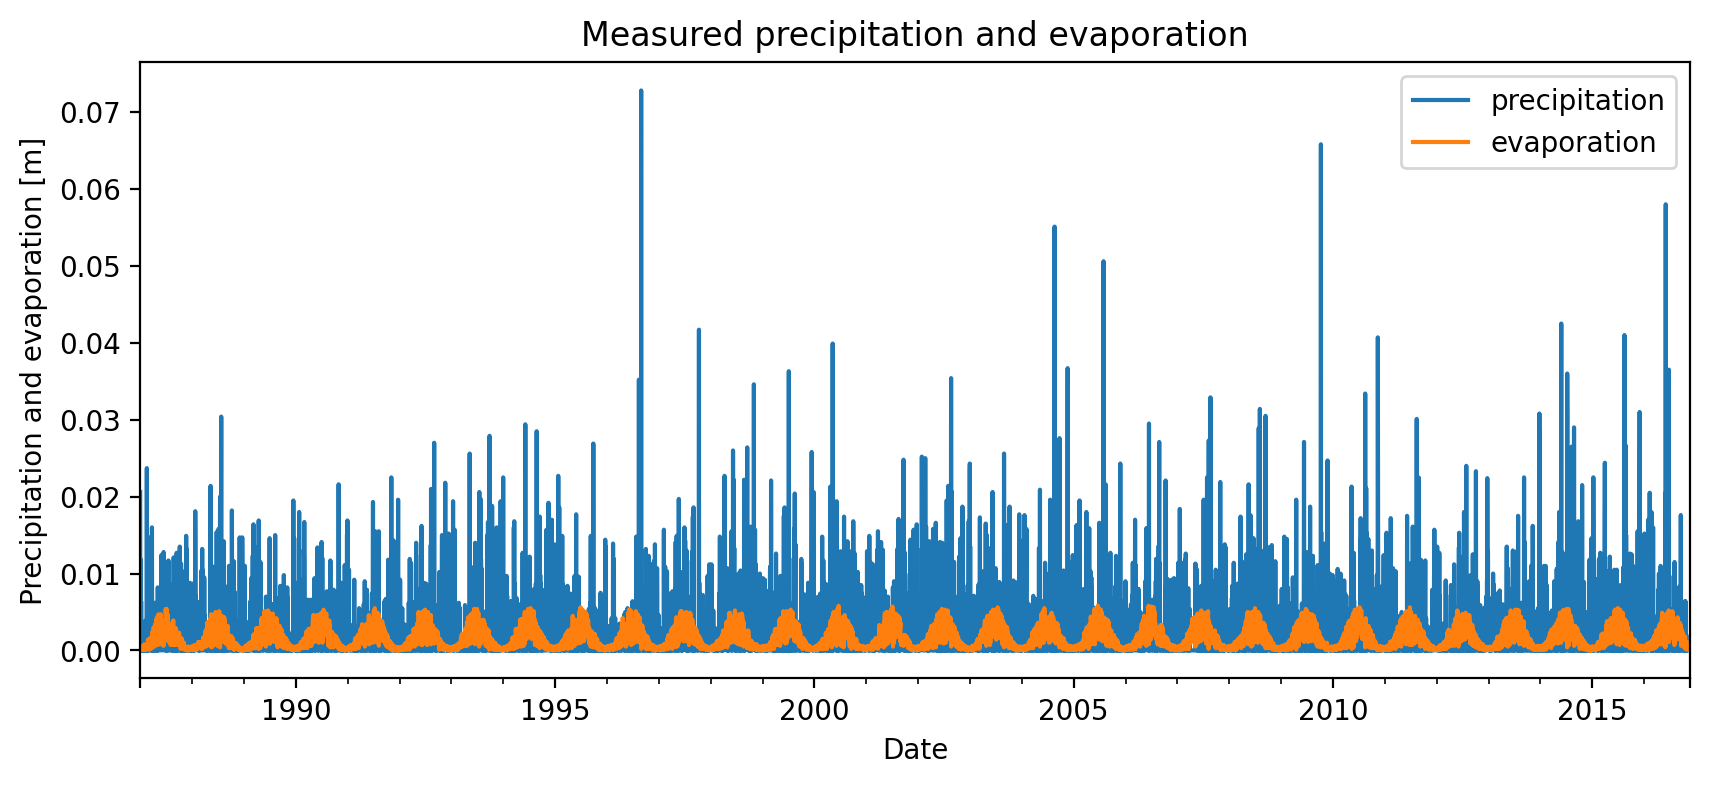

In [3]:
prec = pd.read_csv("data/rain_stepex.csv",
                       index_col=0, parse_dates=True)
evap = pd.read_csv("data/evap_stepex.csv",
                         index_col=0, parse_dates=True)


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
prec.plot(ax=ax, color='C0')
evap.plot(ax=ax, color='C1')

ax.set_ylabel('Precipitation and evaporation [m]')
ax.set_xlabel('Date')
ax.set_title('Measured precipitation and evaporation')
ax.legend(['precipitation', 'evaporation'])
ax.set_xlim(xmin='1987')

### Building the Time Series Model – Example 1

A model is developed for the groundwater head observations. The full time series is used. Since no outliers were found in the data, there is no reason to preprocess the measurement series before applying it in the model.

Precipitation and evaporation are used as explanatory series. For each explanatory series, a response function is selected. The response function describes how the groundwater head reacts to an external influence. It must be defined for each explanatory series, with the user selecting the type of response function and the model optimizing its parameters. For this time series model, the Gamma response function is chosen for both precipitation and evaporation.

The model uses the same response function for both precipitation and evaporation. The relationship between them is described by the formula $R = P - f \cdot E$, where $R$ is the groundwater recharge [m], $P$ is precipitation [m], $f$ is the evaporation factor [-], and $E$ is evaporation [m]. The evaporation factor is optimized by the time series model. In addition to the explanatory series, a constant term is also fitted in the model.

Once the response functions are selected for the explanatory series, the time series model can be optimized.


In [4]:
ml = ps.Model(gws)


sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Gamma(), name='gwa')
ml.add_stressmodel(sm1)


ml.solve(report=False);

The model has an R² of 0.71. Using the optimized time series model, the groundwater head can be simulated. The simulation is shown in the figure below.

In the figure, the measurements and the simulation are shown visually. Below that, the model residuals and noise are displayed. For the different explanatory series, the contributions are shown along with their corresponding response functions. These are the Gamma response functions as optimized by the time series model. Additionally, a table has been included in the figure showing the optimized parameters along with their standard deviations. This table also includes the optimized constant and evaporation factor, among others.


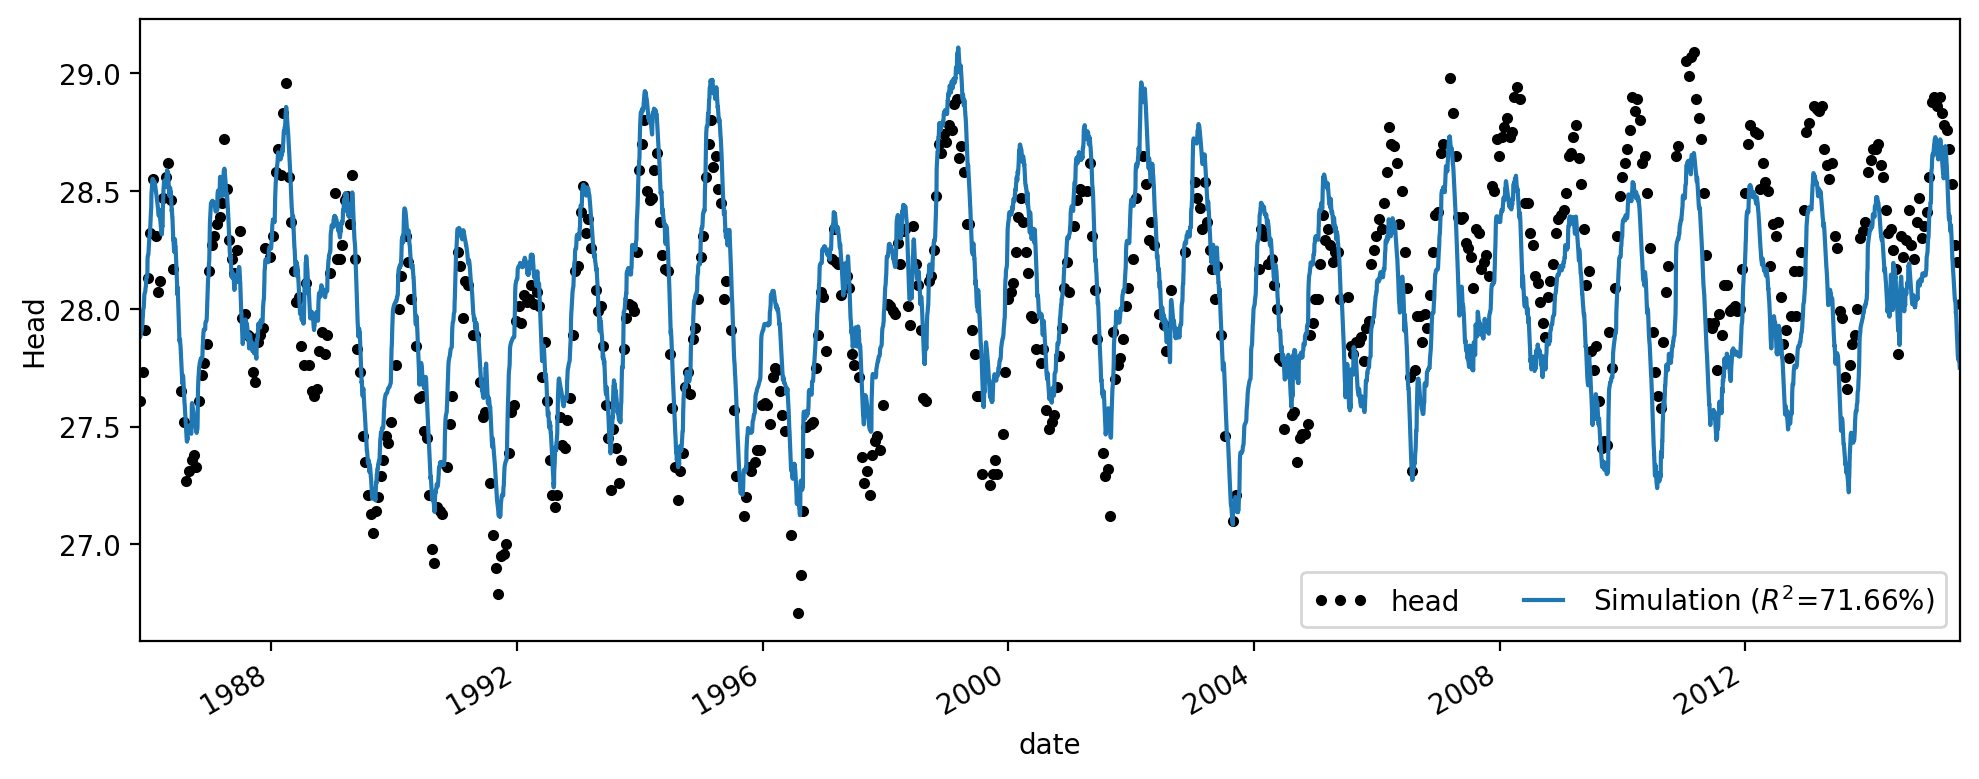

In [5]:
ml.plot(figsize=(10, 4));

The simulation shows that the time series model reasonably reproduces the measured groundwater head. A visual inspection of the simulation reveals that, for the period after 2005, the model underestimates the groundwater head.

This is more clearly visible in the residuals of the series, which are shown in the figure below. In the period before 2005, the model overestimates the measured groundwater head (negative residuals). In the period after 2005, the model underestimates it (positive residuals). This suggests that a change occurred around 2005.

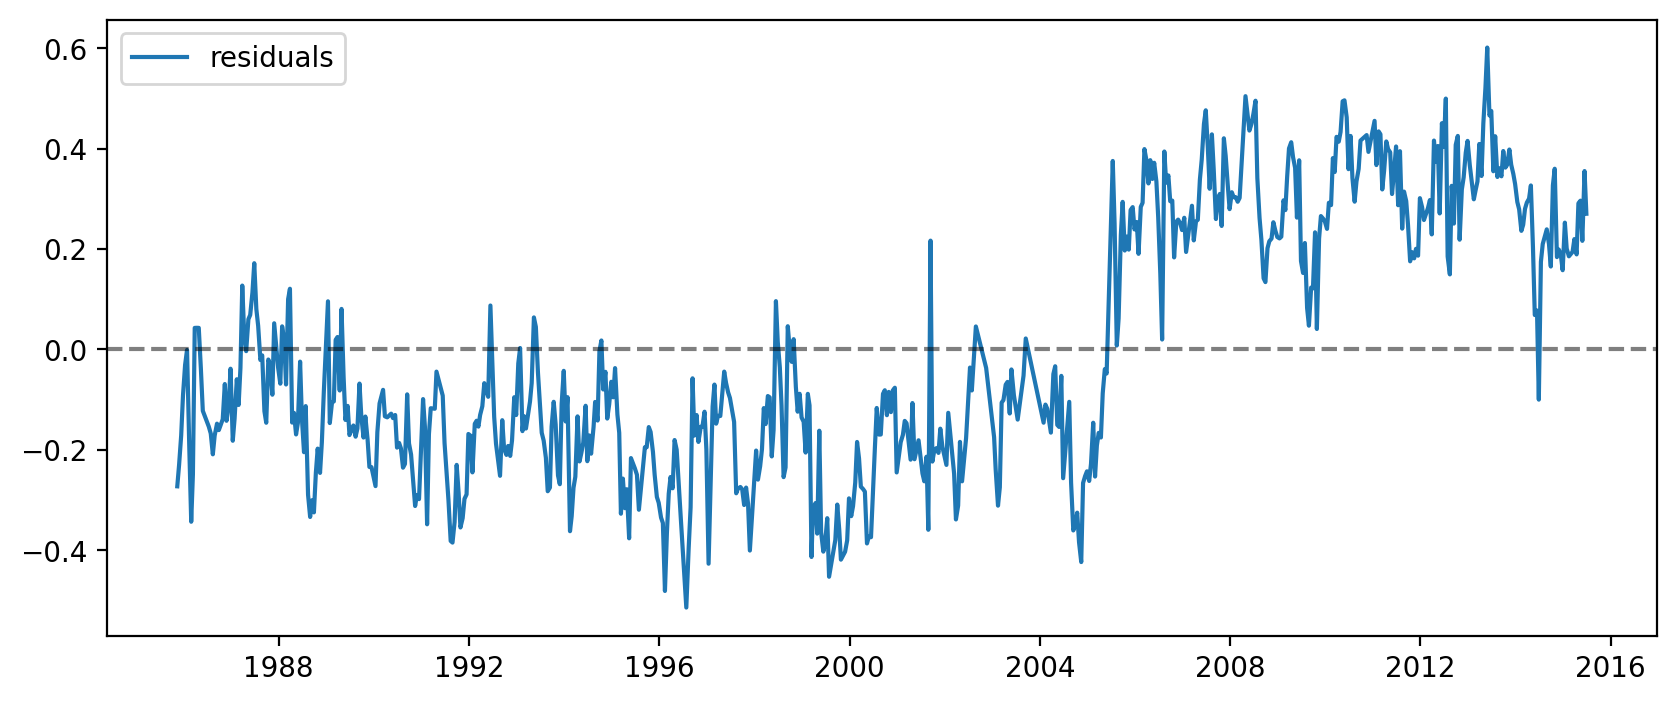

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))

ax.plot(ml.residuals(), label='residuals')
#ax.plot(ml.noise(), label='noise')
ax.axhline(0, color='k', ls='--', alpha=0.5)
ax.legend();

### Impact of the Intervention

The time series model is re-developed with the goal of determining the effect of the intervention. First, an attempt is made to build the model with the addition of a step response, which represents an instantaneous jump in groundwater head. This can be seen as an explanatory series that is equal to 0 (no effect) before June 1, 2005, and equal to 1 (effect present) after June 1, 2005.

This explanatory series is used in setting up the time series model. The step response (or jump) is applied at the moment when the interventions in the area were implemented, on June 1, 2005.

In [7]:
# opzetten model
ml = ps.Model(gws)

# toevoegen van neerslag en verdamping als verklarende reeksen
sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Gamma(), name='gwa')

sm2 = ps.StepModel(tstart=pd.Timestamp('2005-06-01'),
                   name='stap', rfunc=ps.One(), up=None)
ml.add_stressmodel([sm1, sm2])

# oplossen van het tijdreeksmodel
ml.solve(report=False);

The new model has an R² of 0.94, which is significantly higher than the previous model without the step trend, which had an R² of 0.71. The simulation of the new time series model is shown in the figure below.

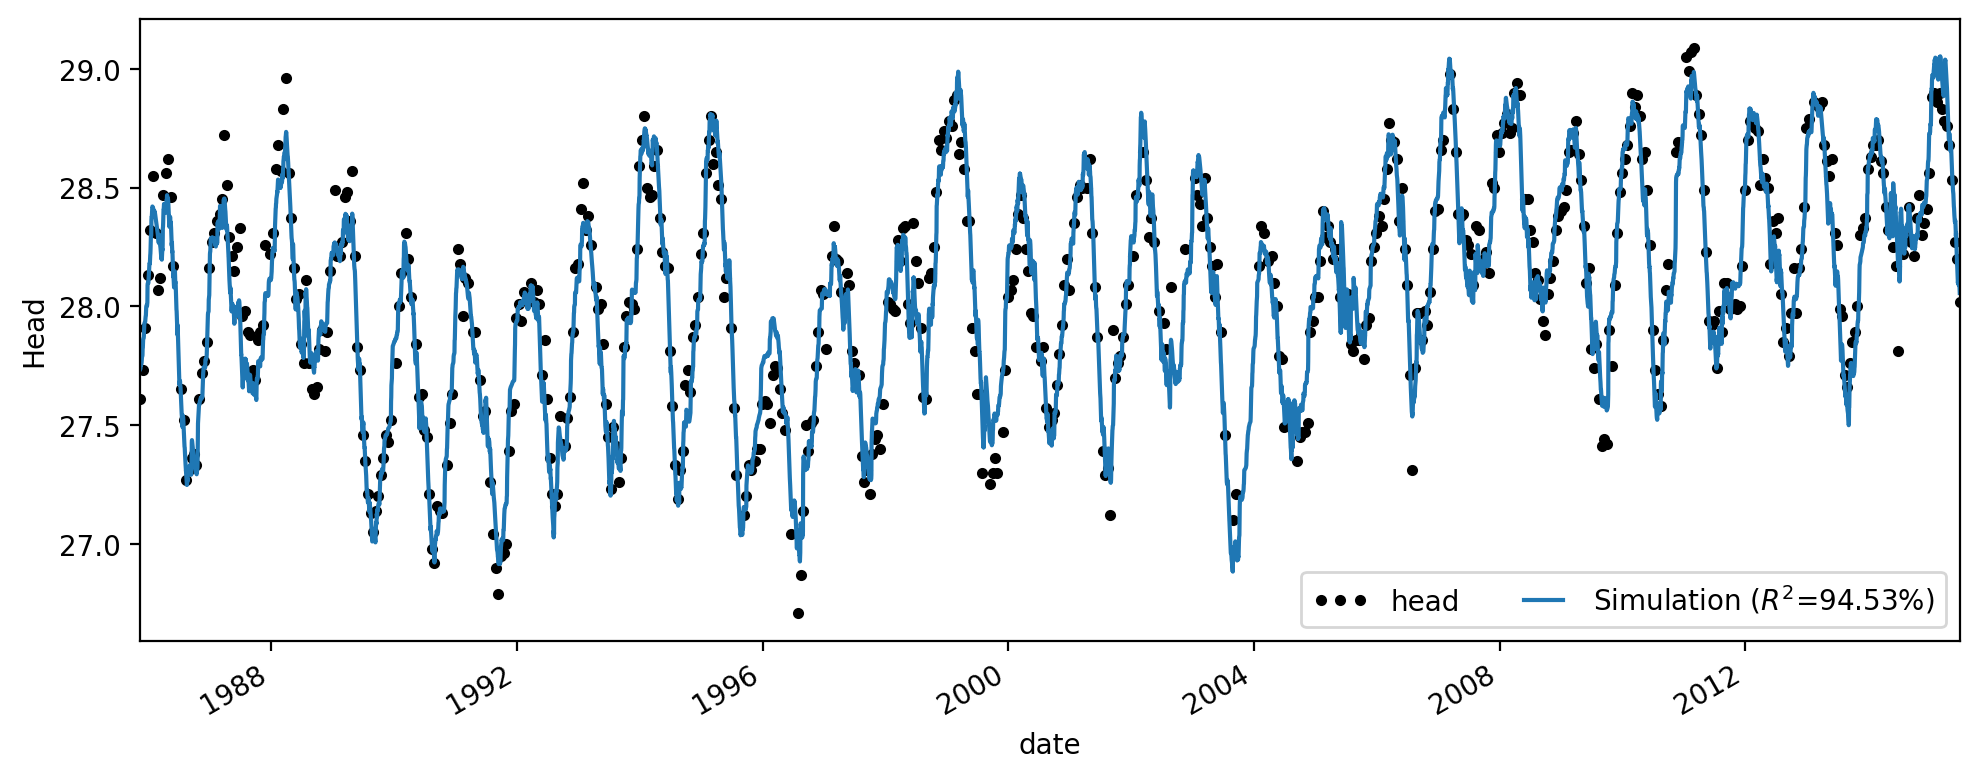

In [8]:
ml.plot(figsize=(10, 4));

For the new model, it is desirable to assess the magnitude of the step and the uncertainty associated with it. To do this, it must be verified whether the results of the time series model are sufficient to reliably estimate this uncertainty. The model must meet certain conditions for this.

When estimating the uncertainty of the model parameters, it is assumed that the model noise is so-called "white noise." Four assumptions are tested to verify this:

- The mean of the noise is zero;
- The values are independent of each other;
- The noise is normally distributed;
- The noise has constant variance.

If the noise meets these criteria, it can be assumed that it is "white noise" and that the standard deviation of the model parameters has been correctly estimated.

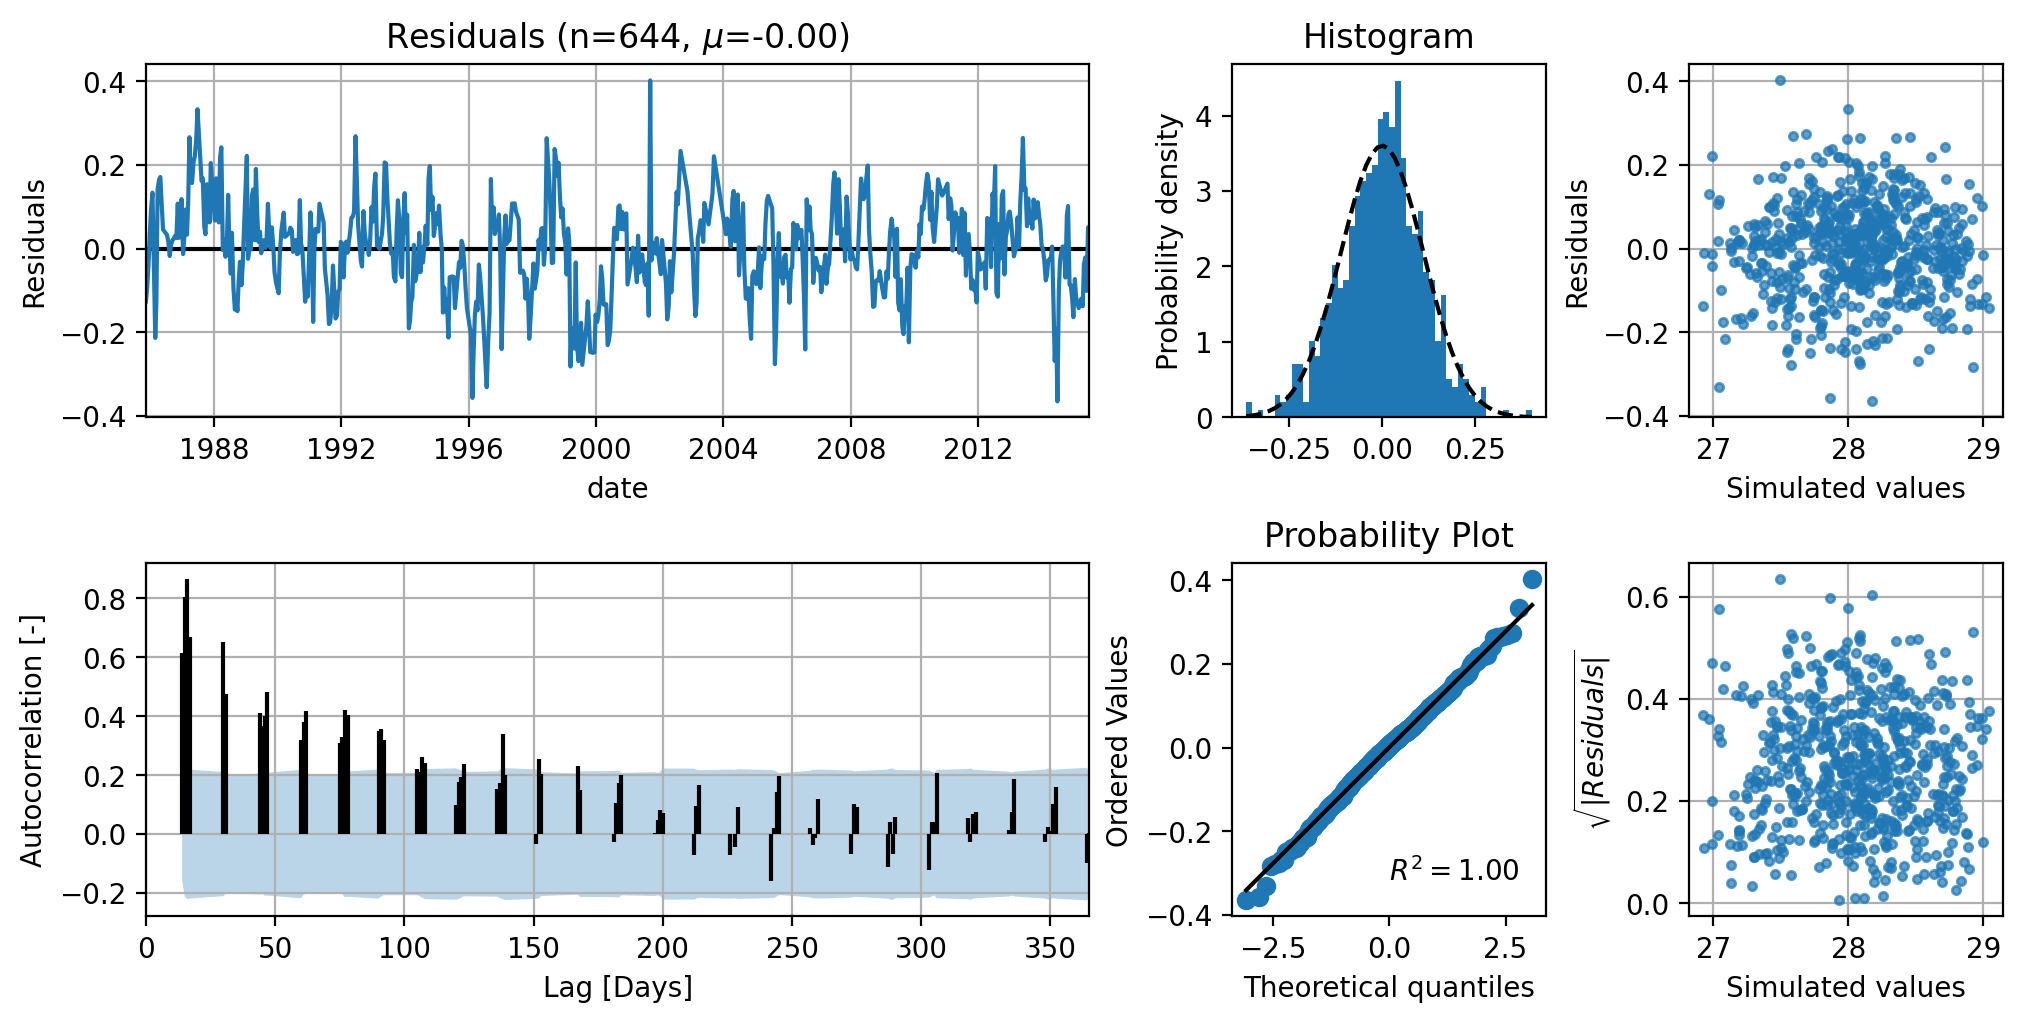

In [9]:
ml.plots.diagnostics();

In the top-left figure, the model noise is shown. It can be observed that there is no clear trend and that the average value ($\mu$) is 0.00. In the bottom-left figure, the autocorrelation of the residuals is shown along with the 95% confidence interval. The rule is that 95% of the autocorrelation values should fall within this interval. In this case, the series meets that requirement.

The top-right figure shows the noise as a distribution, along with a normal distribution fitted to the noise. This figure can be used to assess whether the noise follows a normal distribution. The bottom-right figure can also be used to test for normality. In this case, the noise appears to conform well to a normal distribution.

Based on these results, it is assumed that the noise is "white" noise and that the uncertainties of the model parameters have been correctly estimated. Therefore, it is possible to estimate the uncertainty of the step response. The detailed results of the time series model are shown in the figure below.

The figure shows the residuals of the new time series model. The jump in the residuals that was visible in the original model is no longer present in the new model.

The step calculated by the time series model is 0.48 meters. The 95% confidence interval for the magnitude of this step is between 0.43 and 0.52 meters. This interval is shown in the results.


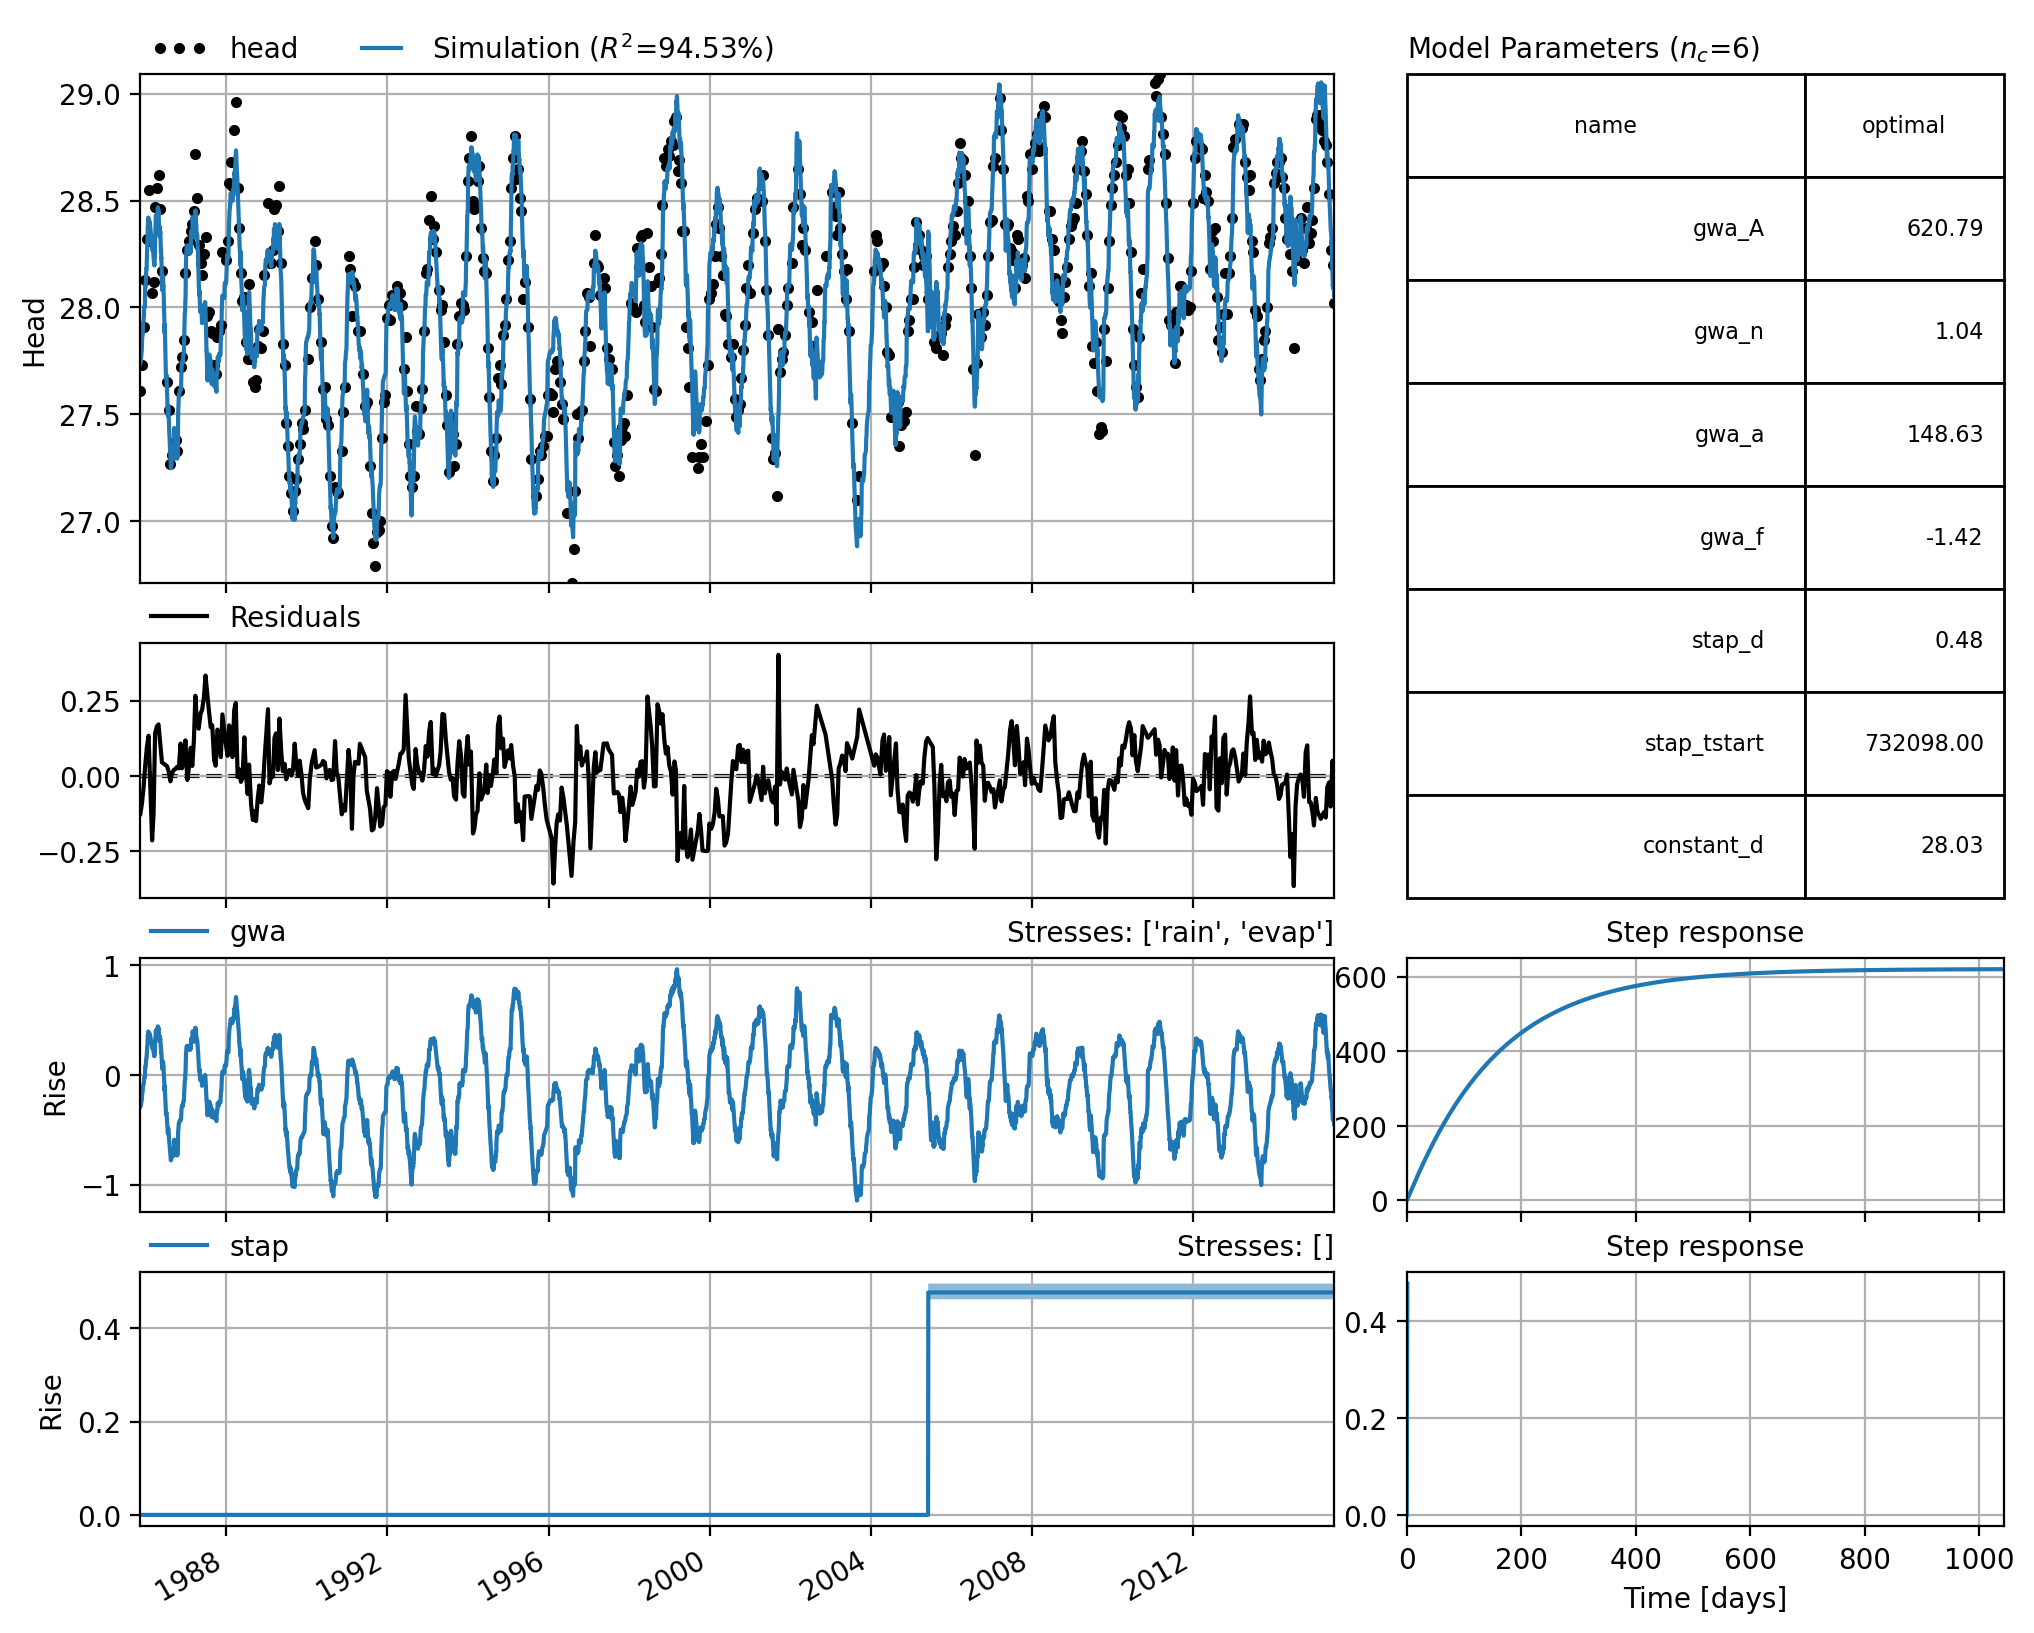

In [10]:
ci = ml.fit.ci_contribution("stap", alpha=0.05)
axes = ml.plots.results(adjust_height=False, figsize=(10, 8))
axes[-3].fill_between(ci.index, ci.iloc[:, 0],
                      ci.iloc[:, 1], zorder=-10, alpha=0.5);

A second method is used to perform the same analysis in order to assess the effects of the intervention. For this, two time series models are developed: one model for the period before the intervention took place (groundwater head series up to May 2005), and one model for the period after the intervention (groundwater head series from September 2005 onward). 

In both cases, precipitation and evaporation are used as explanatory series. As in the previous time series model, the Gamma response function is used for both precipitation and evaporation. No step trend is added to these models.

In [11]:
ml_before = ps.Model(gws[:'2005-05-01'])

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Gamma(), name='gwa')
ml_before.add_stressmodel(sm1)

ml_before.solve(report=False)

ml_after = ps.Model(gws['2005-09-01':])

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Gamma(), name='gwa')
ml_after.add_stressmodel(sm1)

ml_after.solve(report=False);

Using both models, the groundwater head can be simulated for a specific period. With both models, the period from 1995 to 2015 is simulated—covering 10 years before and after the intervention. The figure below shows both simulations, and the difference between the two simulations over this period has also been calculated and displayed.

Text(0.5, 1.0, 'Difference between model before and after intervention')

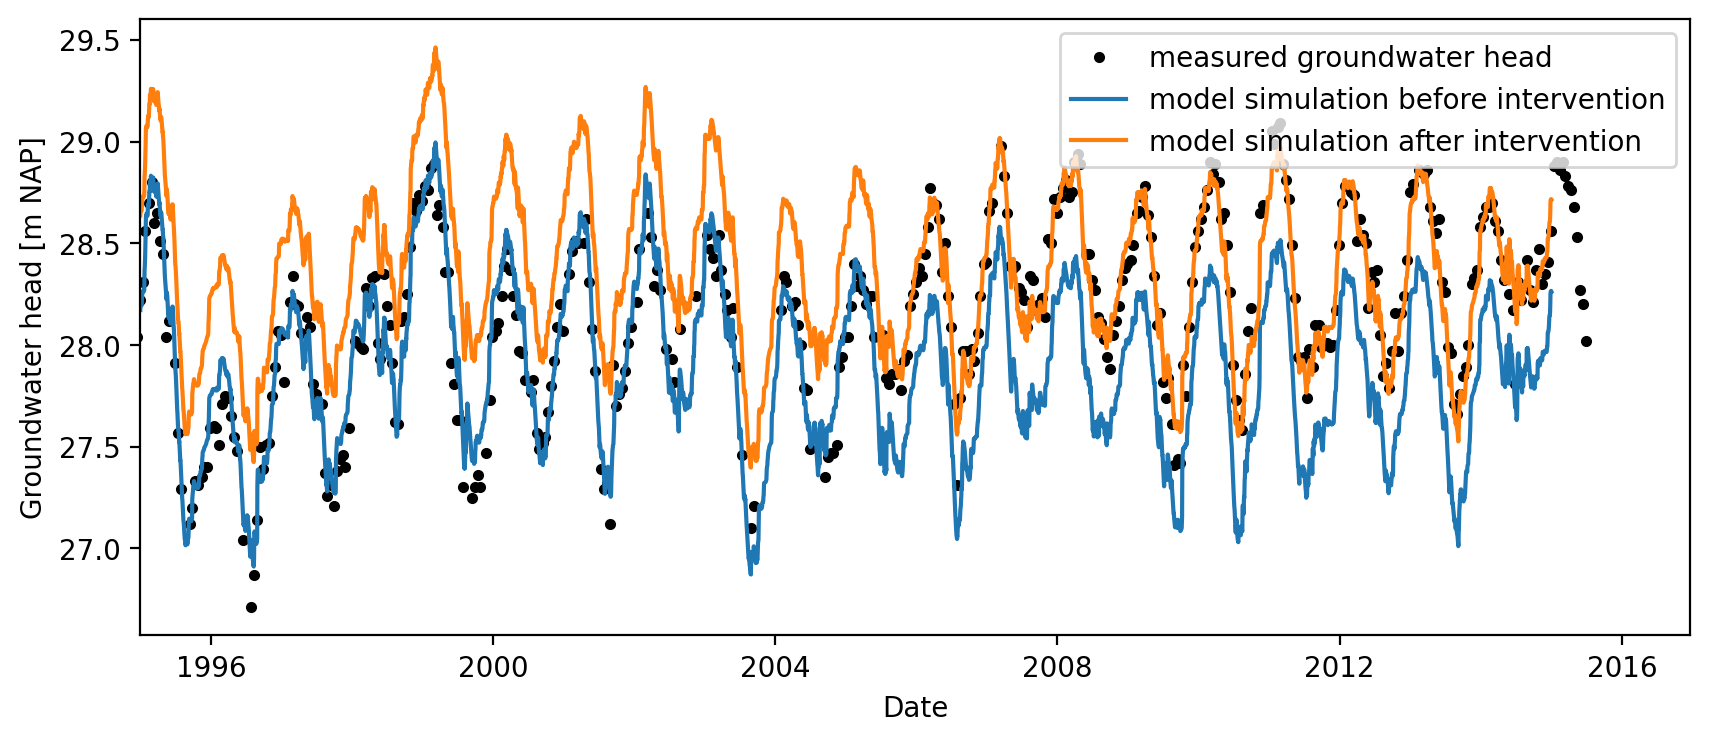

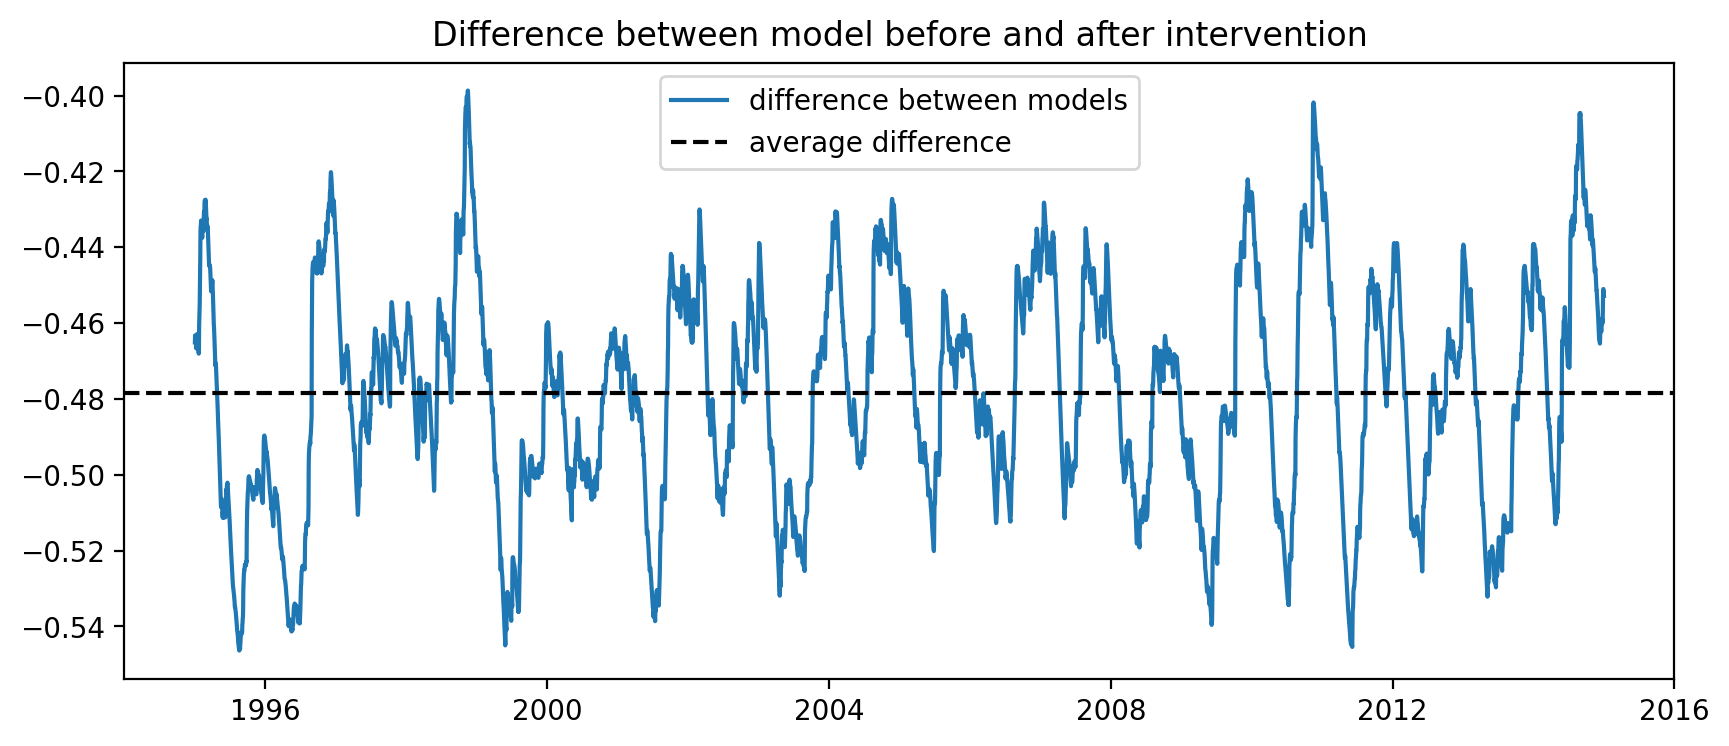

In [12]:
# Plot measured and simulated groundwater head
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(gws, marker='.', color='k', ls='', label='measured groundwater head')
ax.plot(ml_before.simulate(tmin='1995', tmax='2015'),
        label='model simulation before intervention')
ax.plot(ml_after.simulate(tmin='1995', tmax='2015'),
        label='model simulation after intervention')

# Format the figure
ax.set_ylabel('Groundwater head [m NAP]')
ax.set_xlabel('Date')
ax.set_xlim(xmin=pd.Timestamp('1995'))
ax.legend()

# Plot difference between the two model simulations
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot((ml_before.simulate(tmin='1995', tmax='2015') - 
         ml_after.simulate(tmin='1995', tmax='2015')),
        color='C0', label='difference between models')
ax.axhline((ml_before.simulate(tmin='1995', tmax='2015') - 
            ml_after.simulate(tmin='1995', tmax='2015')).mean(),
           color='k', ls='--', label='average difference')
ax.legend()
ax.set_title('Difference between model before and after intervention')


As shown, the difference between the two models lies between 0.4 and 0.6 meters. The average difference is 0.48 meters. This corresponds with the findings from the time series model using the step response function, supporting the conclusion of that model. 

It should be noted, however, that the second analysis does not take into account the uncertainties within the model.

## Part II: Influence of the Watercourse

The water board has installed an observation well near a major watercourse to monitor the groundwater head in the area. The area manager is aware that the groundwater level and the water level in the watercourse are strongly correlated.

During the summer of 2018, the groundwater head dropped significantly due to drought. To prevent this from happening in the future, the possibility of raising the water levels in the watercourse is being considered as a potential solution. The hydrologist of the water board wants to determine how the groundwater head in the area responds to changes in the water level of the watercourse.

### Available Data Example 2

The groundwater head was measured for the period from 2000 to 2020. The measured groundwater head is shown in the figure below. It can be seen that the groundwater head dropped significantly during the summer of 2018.

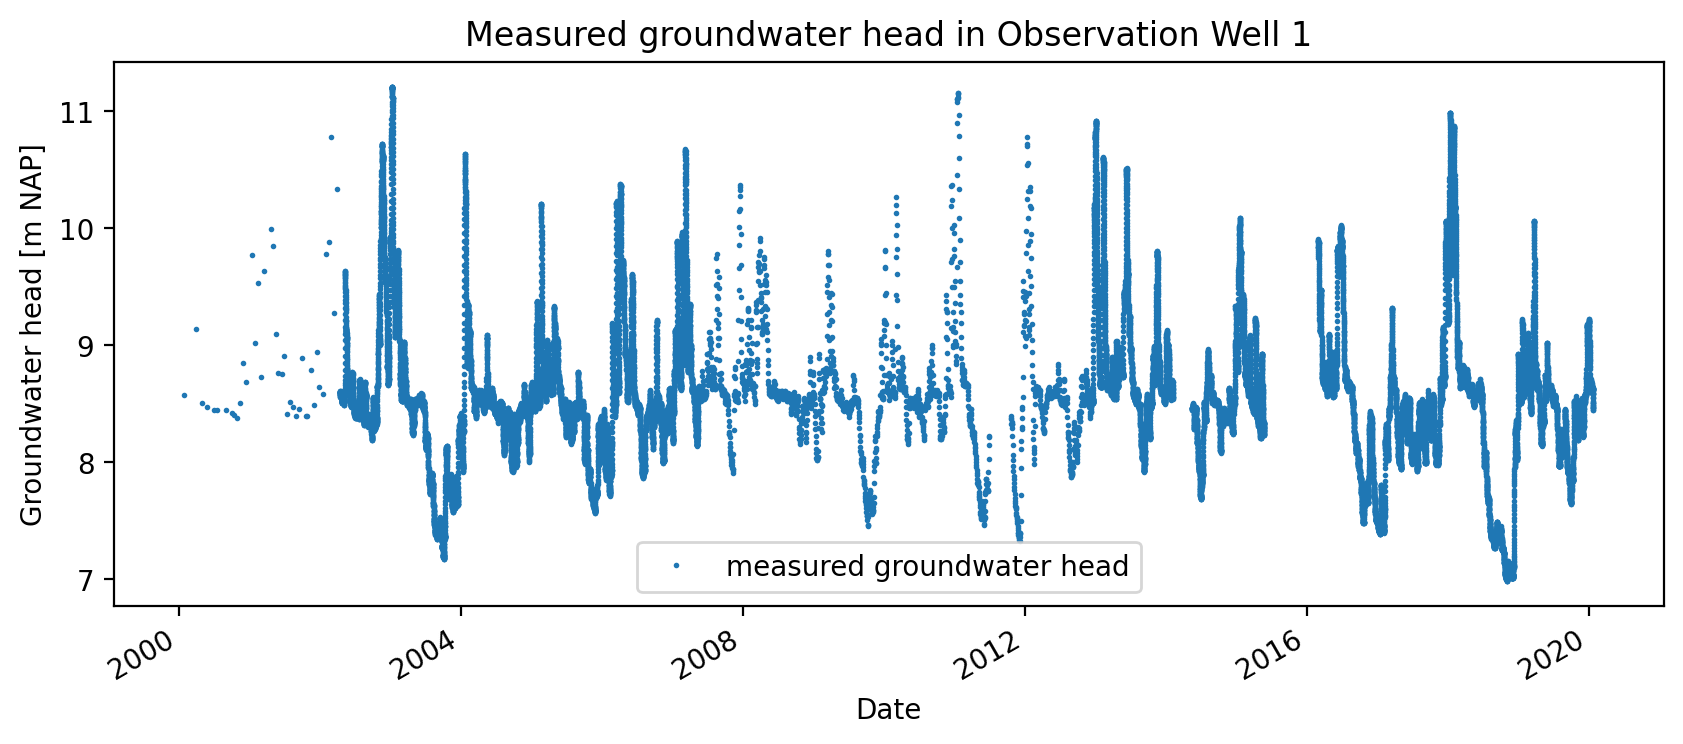

In [13]:
gws = pd.read_csv("data/head_rivex.csv", index_col="Date", parse_dates=True)

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws.plot(ax=ax, color='C0', ls='', marker='.', markersize=2)

ax.set_ylabel('Groundwater head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured groundwater head in Observation Well 1')
ax.legend(['measured groundwater head'])

Precipitation and evaporation data near the area were collected from the nearest KNMI weather station. The precipitation and evaporation are shown in the figure below

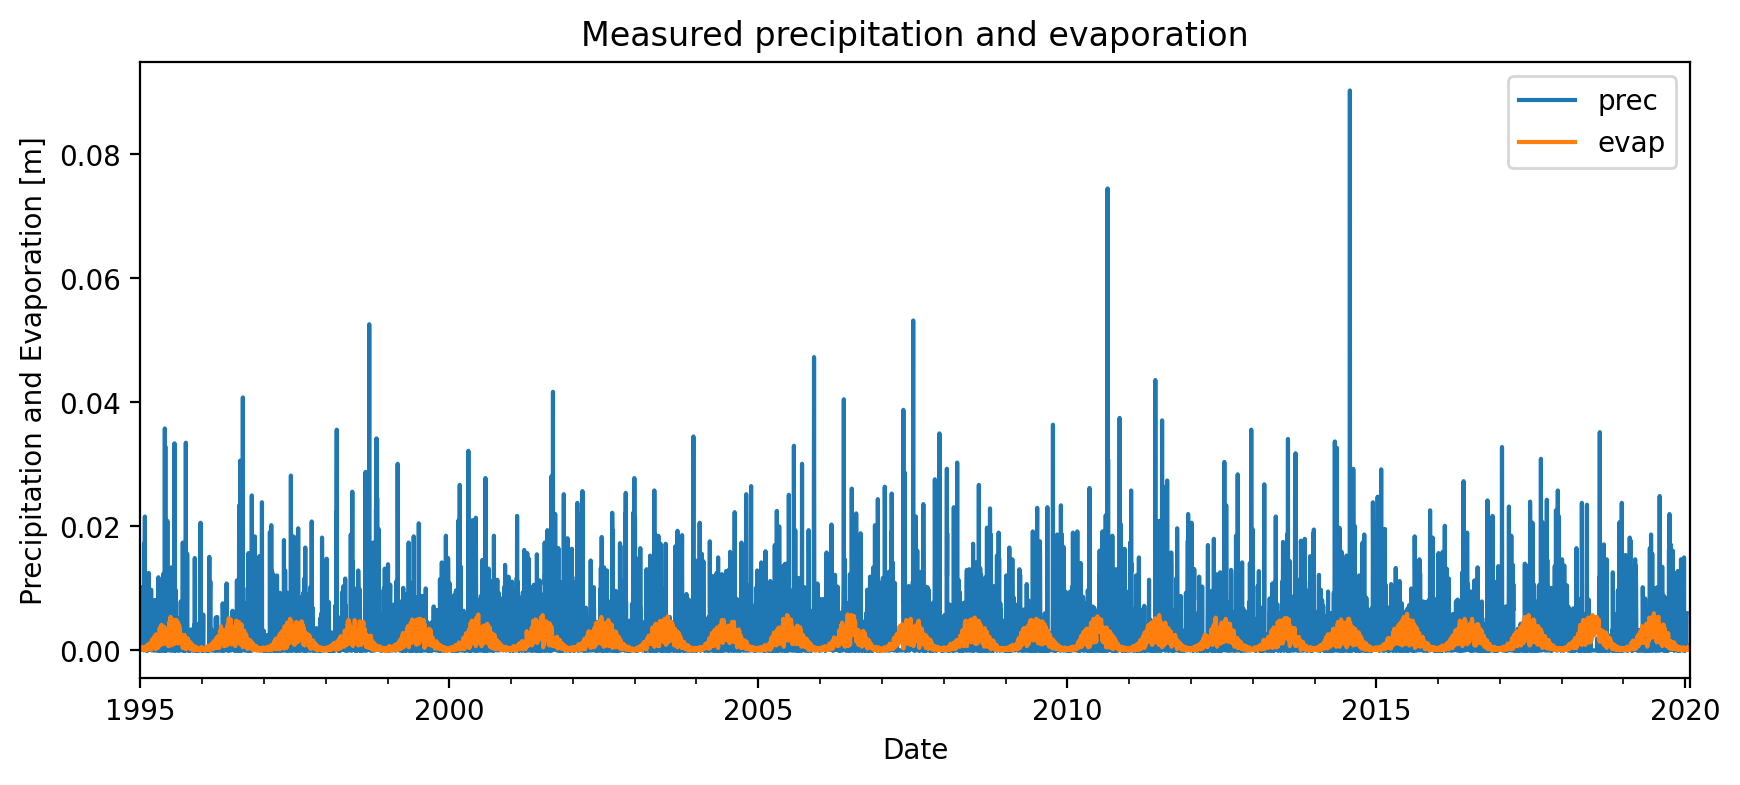

In [14]:
prec = pd.read_csv("data/prec_rivex.csv",
                       index_col="Date", parse_dates=True)
evap = pd.read_csv("data/evap_rivex.csv",
                         index_col="Date", parse_dates=True)

# plotten van de neerslag en verdamping
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
prec.plot(ax=ax, color='C0')
evap.plot(ax=ax, color='C1')

# opmaken van de figuur
ax.set_ylabel('Precipitation and Evaporation [m]')
ax.set_xlabel('Date')
ax.set_title('Measured precipitation and evaporation')
ax.legend([f'prec',
          f'evap'])
ax.set_xlim(xmin='1995');

In addition to precipitation and evaporation, the water level in the watercourse is used as an explanatory series in the time series model. The water board measured the water level in the watercourse for the period from 1995 to 2020. The variation in water level relative to the target level is shown in the figure below. The measurement series shows that the water level in the summer of 2018 was very low—approximately 2 meters below the target level.

(9131.0, 18198.0)

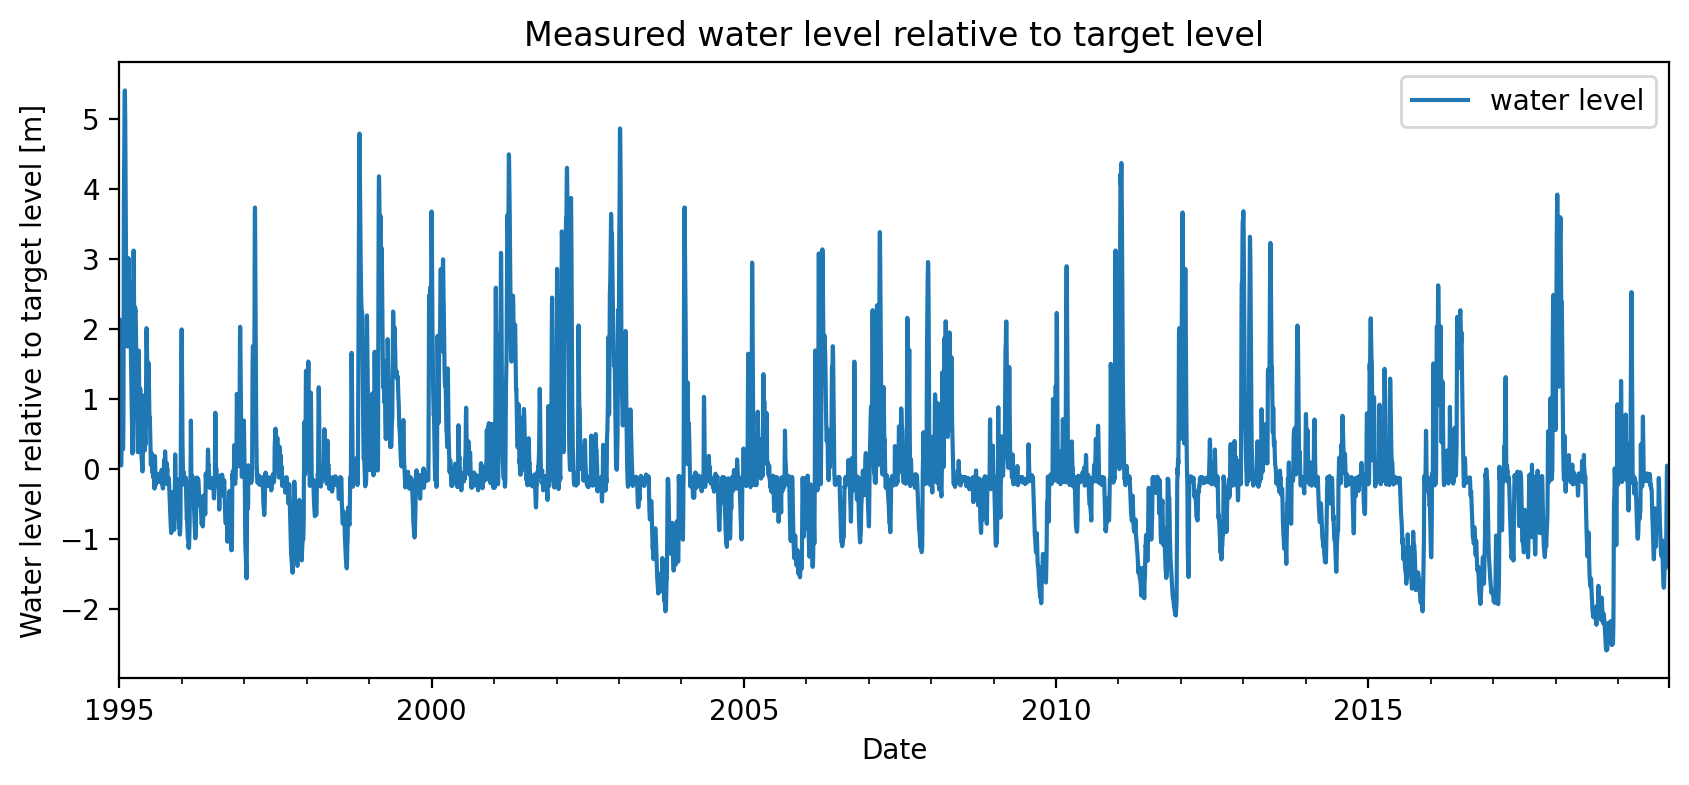

In [15]:
waterlevel = pd.read_csv("data/waterlevel_rivex.csv",
                         index_col="Date", parse_dates=True)


fig, ax = plt.subplots(1, 1, figsize=(10, 4))
waterlevel.plot(ax=ax, color='C0')

ax.set_ylabel('Water level relative to target level [m]')
ax.set_xlabel('Date')
ax.set_title('Measured water level relative to target level')
ax.legend(['water level'])
ax.set_xlim(xmin='1995')



### Preprocessing Time Series – Example 2

The measured groundwater head has a measurement frequency of once every 3 hours. The time series for the water level in the watercourse has a daily measurement frequency, as do the precipitation and evaporation data. Therefore, the groundwater head time series is resampled to a daily frequency. For this resampling, the average groundwater head per day is used.

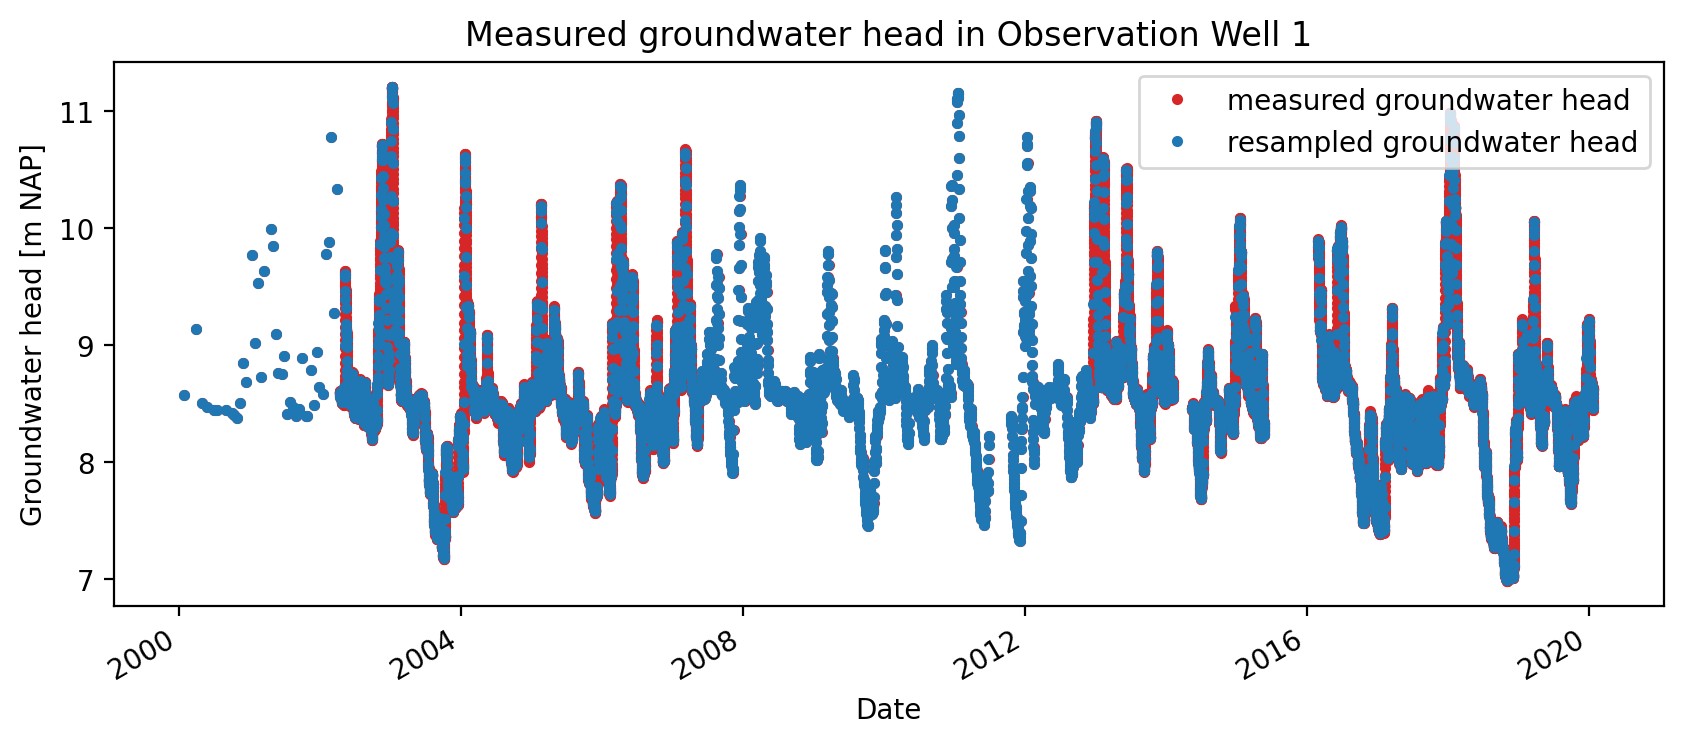

In [16]:
gws_r = gws.resample("D").mean().dropna()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
gws.plot(ax=ax, color='C3', ls='', marker='.')
gws_r.plot(ax=ax, color='C0', ls='', marker='.')

ax.set_ylabel('Groundwater head [m NAP]')
ax.set_xlabel('Date')
ax.set_title('Measured groundwater head in Observation Well 1')
ax.legend(['measured groundwater head', 'resampled groundwater head'])

### Setting Up the Model – Example 2

Using the processed time series, a time series model is set up for the period starting from 2000. Initially, a model is developed using only precipitation and evaporation as explanatory series. For both of these series, the Exponential response function is chosen.


In [17]:
ml = ps.Model(gws_r.loc["2000-01-01":])

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name='gwa')
ml.add_stressmodel(sm1)

ml.solve(report=False);

The simulated groundwater head is shown in the figure below. It can be seen that the time series model does not provide a good explanation for the measured groundwater head. The model is unable to simulate the variation in groundwater head.

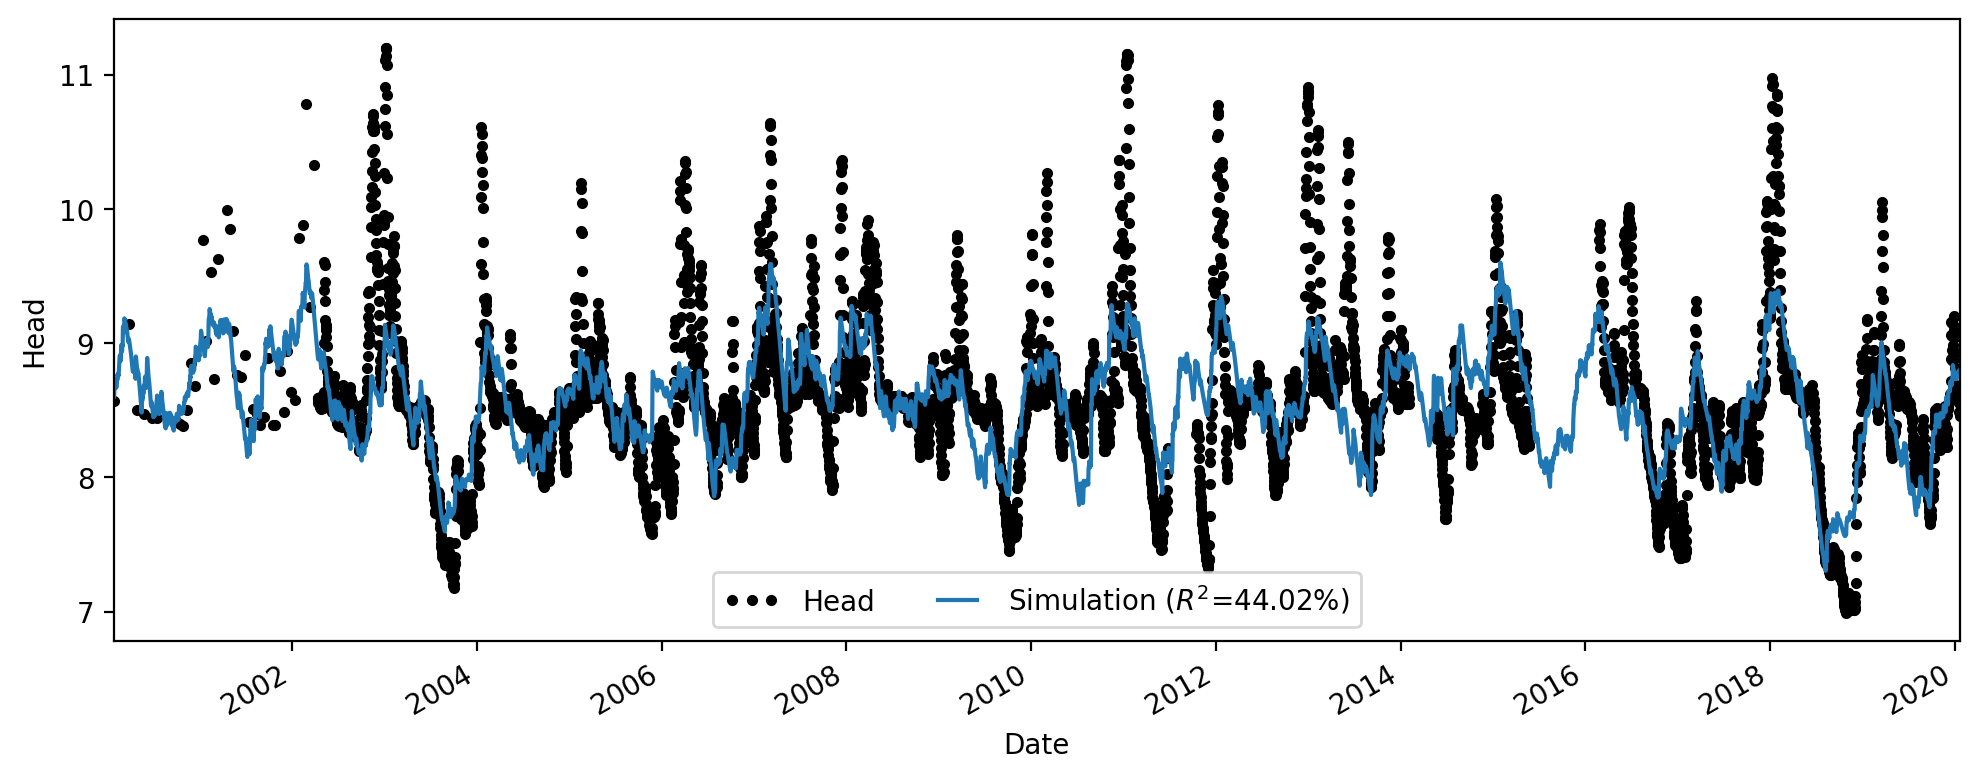

In [18]:
ml.plot(figsize=(10, 4));

Another time series model is developed, this time with the addition of the measured water level in the watercourse as an explanatory series. For this explanatory series, the Gamma response function is selected.

The variation in the water level is approximately 6 to 7 meters, while the variation in the groundwater head is about 4 meters. Since the groundwater head appears to be strongly dependent on the water level in the watercourse, a visual inspection allows for a rough estimation of the groundwater head's response to the watercourse. This response is expected to be around 57% to 66% (between 4/6 and 4/7).

In [19]:
ml2 = ps.Model(gws_r.loc["2000-01-01":])

sm1 = ps.RechargeModel(prec, evap, rfunc=ps.Exponential(), name='gwa')

sm2 = ps.StressModel(stress=waterlevel, rfunc=ps.Gamma(),
                     name='waterlevel', settings='waterlevel')
ml2.add_stressmodel([sm1, sm2])

ml2.solve(report=False)

The simulation of the time series model is shown in the figure below. It can be seen that the model simulates the measured groundwater head significantly better than the time series model without the water level in the watercourse. The R² of this model is 0.93, compared to 0.38 for the first model. It also shows that the model provides a good estimate of the groundwater head during the summer of 2018.

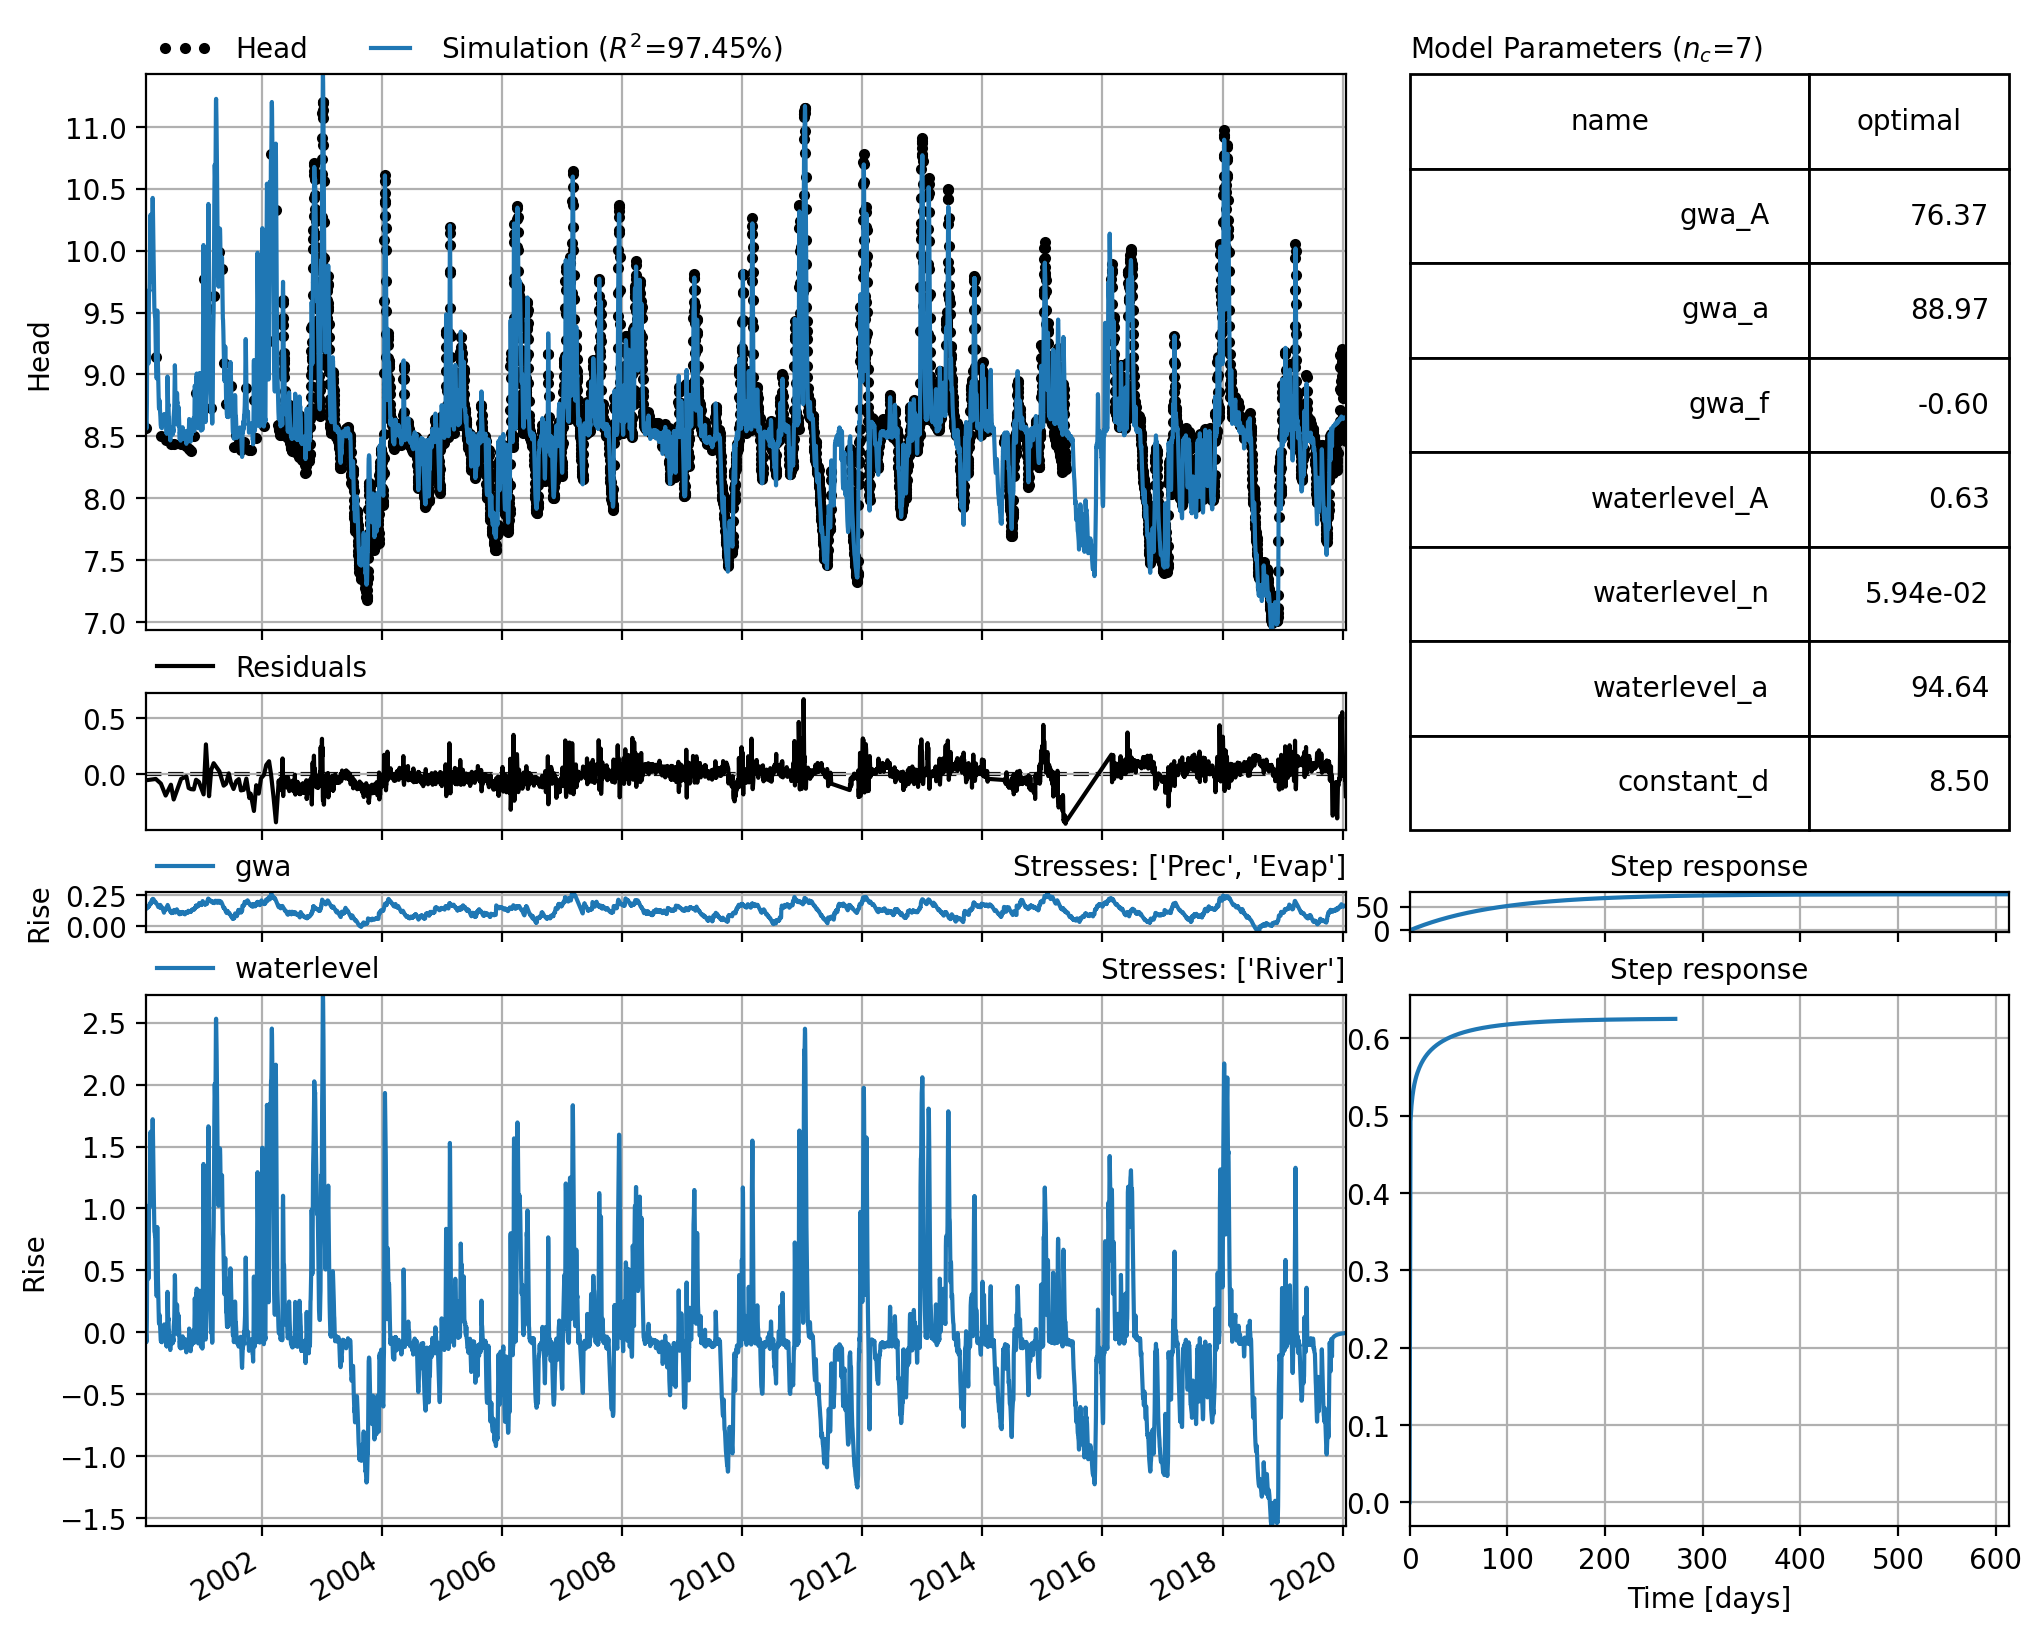

In [20]:
ml2.plots.results(figsize=(10, 8));

### Assessing the Influence of the Watercourse

The figure below shows the contributions of the explanatory series to the measured groundwater head. It can be seen that variations in the water level result in a contribution of approximately -2 to 2 meters to the measured groundwater head. The watercourse contributes the most to the variation in groundwater head, while precipitation and evaporation have only a minor influence.

The stationary value of the response to the watercourse is 0.57 meters. This means that the groundwater head rises by 0.57 meters for every 1-meter increase in the water level of the watercourse. This aligns well with the estimate made earlier based on visual inspection of the series. It should be noted, however, that in this case the uncertainty in the magnitude of the response was not quantified.

With this information, the hydrologist can advise the water board. The time series model shows that the watercourse has a significant influence on the groundwater head in the area. In addition, the model can be used to estimate how much the water level in the watercourse can be lowered before the groundwater head drops below a critical level where drought damage may occur in the area surrounding the observation well.

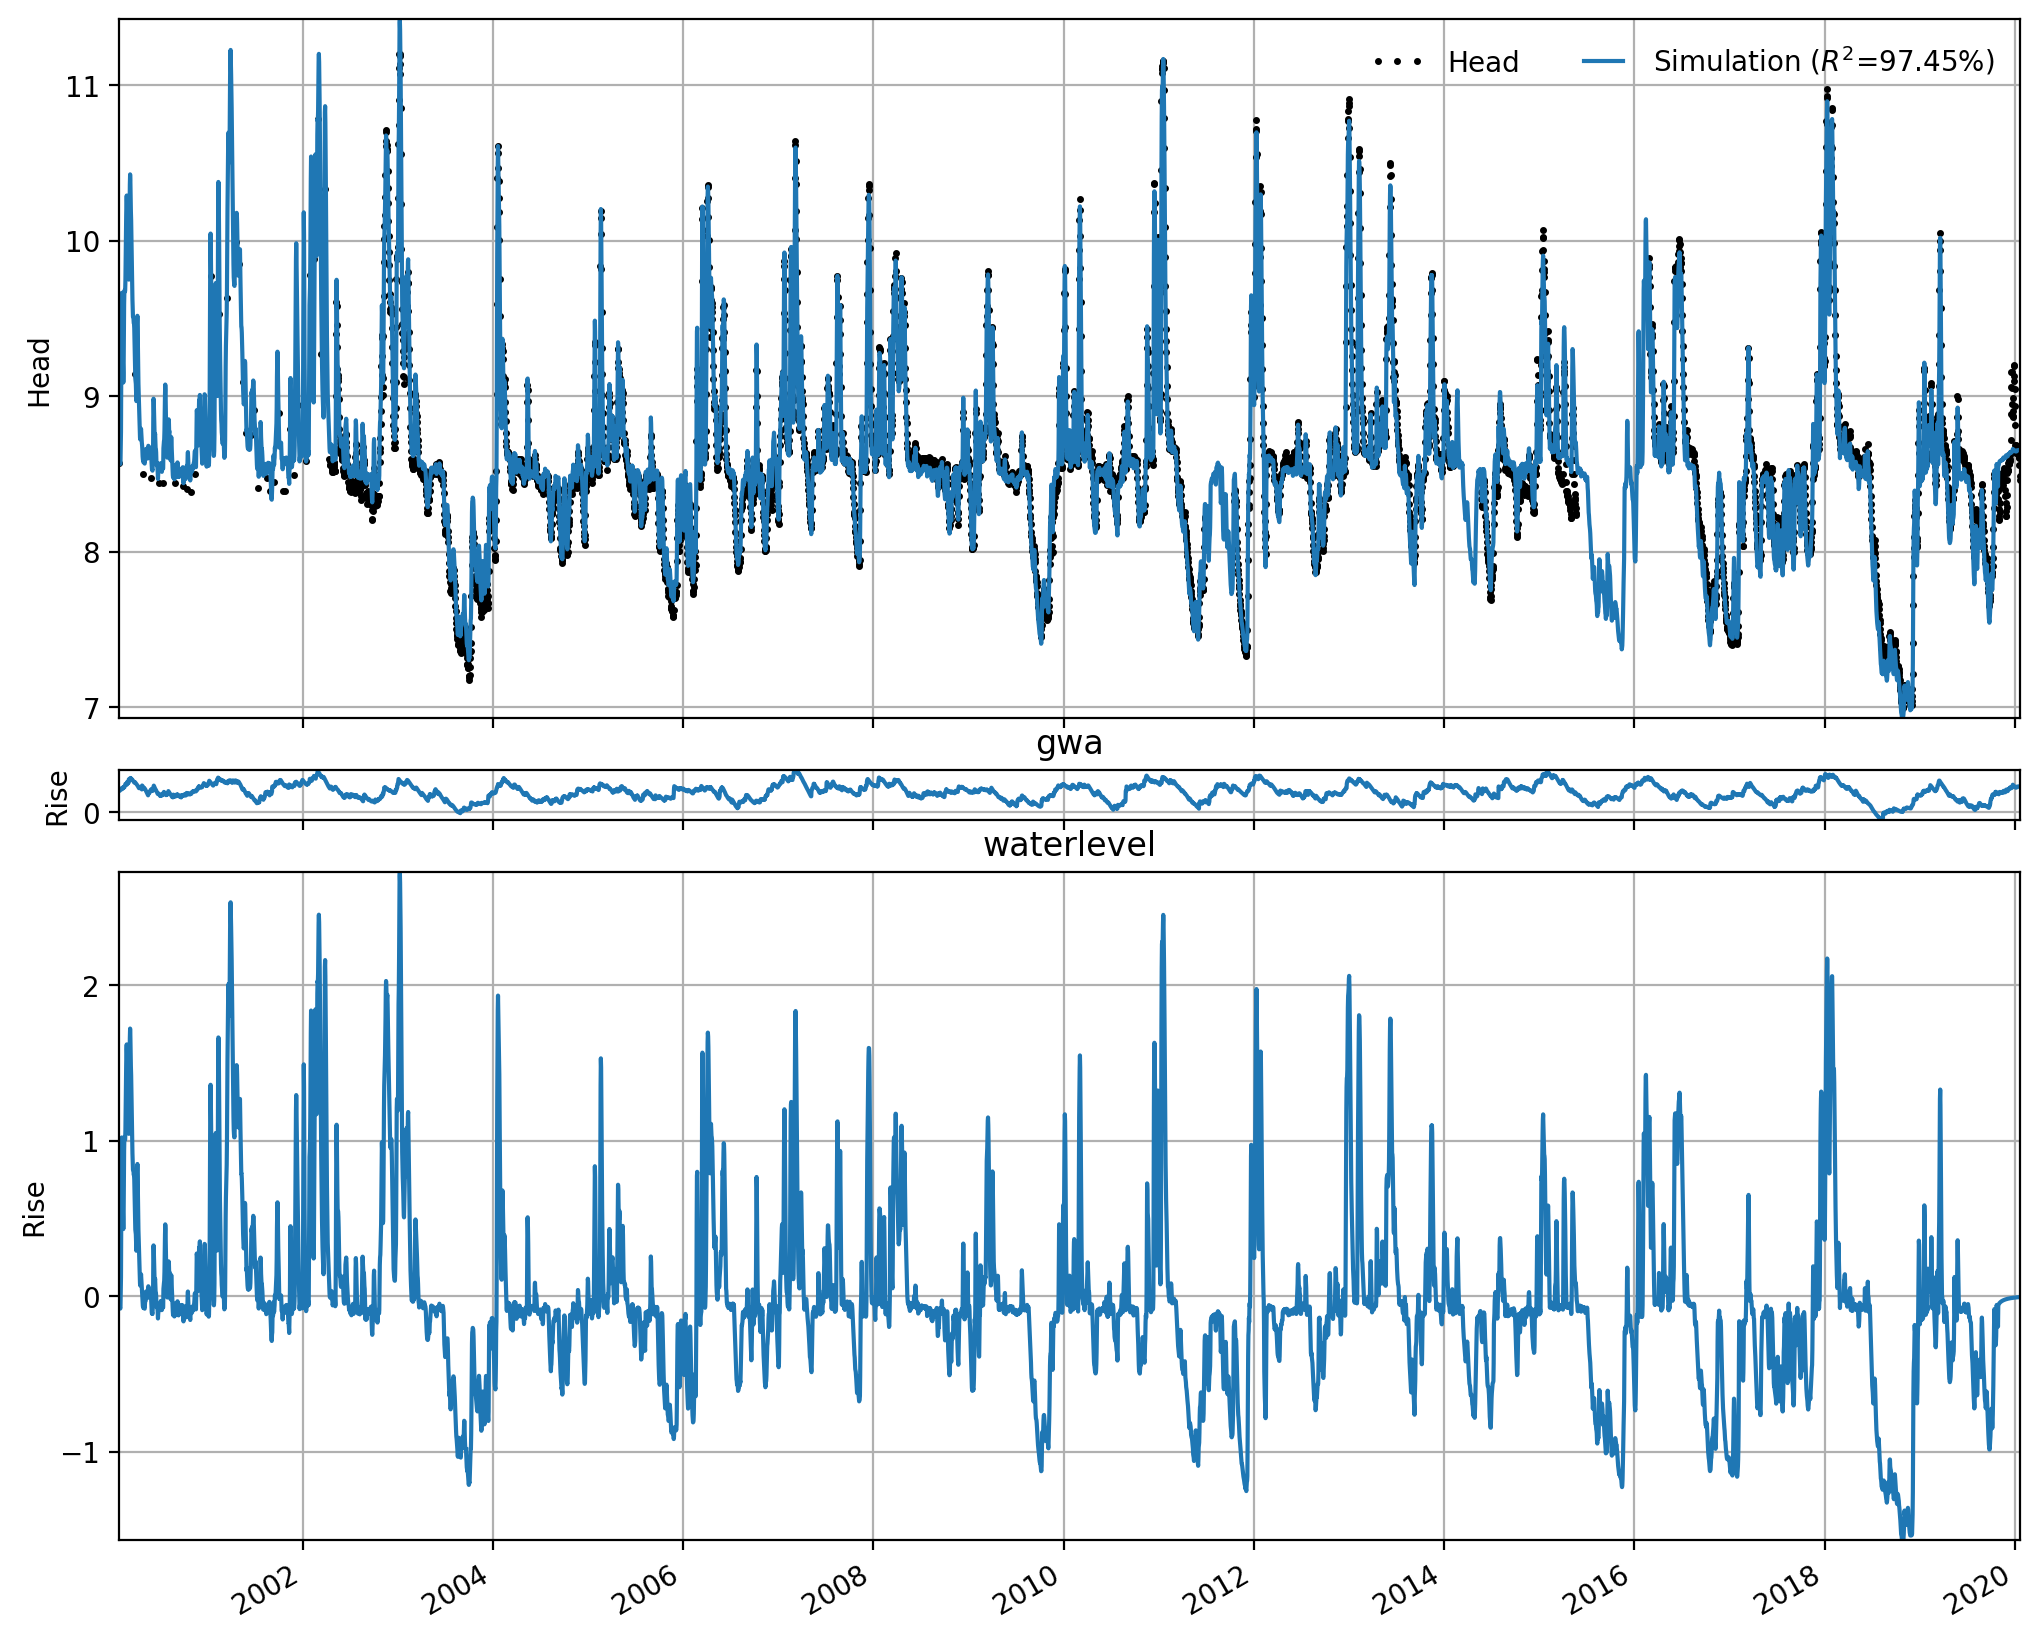

In [21]:
ml2.plots.decomposition(split=False, figsize=(10, 8));